In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import spacy
nlp = spacy.load('en_core_web_lg')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, linear_kernel

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

# Recommender

### Read in Data

In [2]:
recipes = pd.read_csv('data/compressed_clean.csv', compression='gzip')
verb_annot = pd.read_csv('data/concise_verbs.csv')
recipes.head()

C:\Users\leejl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title,method,ingredients,url,ingredient_tokens
0,"Lentil, Apple, and Turkey Wrap","1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool. 2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper. 3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.","['4 cups low-sodium vegetable or chicken stock', '1 cup dried brown lentils', '1/2 cup dried french green lentils', '2 stalks celery, chopped', '1 large carrot, peeled and chopped', '1 sprig fresh thyme', '1 teaspoon kosher salt', '1 medium tomato, cored, seeded, and diced', '1 small fuji apple, cored and diced', '1 tablespoon freshly squeezed lemon juice', '2 teaspoons extra-virgin olive oil', 'freshly ground black pepper to taste', '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas', '3/4 pound turkey breast, thinly sliced', '1/2 head bibb lettuce']",NaN,vegetable lentils lentils celery carrot thyme tomato juice oil pepper lavash tortillas breast
1,Boudin Blanc Terrine with Red Onion Confit,"Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and let stand 30 minutes. Chill overnight. Preheat oven to 325°F. Line 7-cup pâté or bread pan with plastic wrap. Melt butter in heavy small skillet over low heat. Add remaining 5 shallots. Cover and cook until very soft, stirring occasionally, about 15 minutes. Transfer to processor. Add pork, eggs, flour and Port and puree. Strain cream mixture, pressing on solids to extract as much liquid as possible. With processor running, add cream through feed tube and process just until combined with pork. Transfer to large bowl. Mix in currants. Spoon mixture into prepared pan. Cover with foil. Place pan in large pan. Add boiling water to larger pan to within 1/2 inch of top of terrine. Bake until terrine begins to shrink from sides of pan and knife inserted into center comes out clean, about 1 1/2 hours. Uncover and cool on rack. Chill until cold. (Can be made 3 days ahead. Cover and chill.) Line platter with lettuce. Arrange terrine atop. Sprinkle with pepper and parsley. Garnish with bay leaves. Spoon confit around sides. Serve with bread. Heat oil in heavy large skillet over medium-high heat. Add onions and sauté until crisp-tender, about 8 minutes. Add all remaining ingredients and stir until reduced to thick glaze, about 4 minutes. Season with salt and pepper. (Can be prepared 2 days ahead. Cover and chill.) Serve warm or at room temperature.","['1 1/2 cups whipping cream', '2 medium onions, chopped', '5 teaspoons salt', '3 bay leaves', '3 whole cloves', '1 large garlic clove, crushed', '1 teaspoon pepper', '1/8 teaspoon ground nutmeg', 'pinch of dried thyme, crumbled', '8 large shallots, minced', '1 tablespoon butter', '1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled', '3 eggs', '6 tablespoon all purpose flour', '1/4 cup tawny port', '3 tablespoons dried currants, minced', 'lettuce leaves', 'cracked peppercorns', 'minced fresh parsley', 'bay leaves', 'french bread baguette slices', '3 tablespoons olive oil', '2 large red onions, halved, sliced', '3 tablespoons dried currants', '3 tablespoons red wine vinegar', '1 tablespoons canned chicken broth', '2 teaspoons chopped fresh thyme or 3/4 teaspoon dried, crumbled', '1/2 teaspoon sugar']",

### Utilities

In [22]:
# moves, readability, l-score, ingredient count

def manual_difficulty_weighting(method_string):
    '''
    matches method string to weighted actions in verb_annot, returns weight value
    '''
    doc = nlp(method_string)

    # set initial weights
    weights = 0 

    # loop through tokens
    for tok in doc:
        # check if token is the root verb
        if tok.pos_ == 'VERB' and tok.dep_ == 'ROOT': 
            # check if root verb is on the annotated verb list
            if tok.lemma_ in verb_annot['verb'].values: 
                # increase weights by value
                weights += verb_annot.loc[verb_annot['verb'] == tok.lemma_, 'skill_level'].values[0] 

    return int(weights * 2)

def action_counter(method_string):
    '''
    hunts for root verb, counts number of actions/moves
    '''  
    doc = nlp(method_string)
    actions = 0
    for tok in doc:
        if tok.pos_ == 'VERB' and tok.dep_ == 'ROOT':
            actions += 1
    return actions

def readability_score(method_string):
    '''
    returns 40% of the LIX readability score
    '''
    doc = nlp(method_string)
    words = [tok for tok in doc if tok.is_alpha]

    # count words
    n_words = len(words)

    # count words > 6
    n_long_words = len([word for word in words if len(word) > 6])
    
    # count sentences
    n_sents = len(list(doc.sents))
    
    # calculate LIX
    try:
        rlw = n_long_words / n_words
    except:
        rlw = 0
    try:
        asl = n_words / n_sents
    except:
        asl = 0
    readability = 40 * rlw + asl
    return round(readability)

def token_counter(ingredient_tokens):
    return len(ingredient_tokens.split())

In [4]:
def big_filter(input_list):
    '''
    filters full dataset for just ingredients in input_list
    applies difficulty metrics
    '''
    print('Scanning for What You Have...')

    # for one ingredient
    # if len(input_list) == 1:
    #    result = recipes.loc[recipes['ingredient_tokens'].str.contains(input_list[0]), :]

    # for two
    # if len(input_list) == 2:
    #    result = recipes.loc[recipes['ingredient_tokens'].str.contains(input_list[0]) &
    #                         recipes['ingredient_tokens'].str.contains(input_list[1]), :]

    # for three
    # if len(input_list) == 3:
    result = recipes.loc[recipes['ingredient_tokens'].str.contains(input_list[0]) &
                        recipes['ingredient_tokens'].str.contains(input_list[1]) &
                        recipes['ingredient_tokens'].str.contains(input_list[2]), :].copy()

    print('Counting Ingredients...')
    result['n_ingr'] = result['ingredient_tokens'].apply(token_counter)

    print('Calculating Readability...')
    result['readability'] = result['method'].apply(readability_score)

    print('Counting Number of Moves...')
    result['n_moves'] = result['method'].apply(action_counter)

    print('Calculating L-Score...')
    result['l_score'] = result['method'].apply(manual_difficulty_weighting)

    print('Calculating Total Effort...')
    # effort is scaled back by half for better plotting
    result['effort'] = (result['n_ingr'] + result['readability'] + result['n_moves'] + result['l_score']) * .5

    # create effort quartiles
    print('Appending Quartiles...')
    result['effort_quartile'] = pd.qcut(result['effort'], 4, labels=False)
    
    # drop any duplicates, based on ingredients
    result.drop_duplicates(['ingredient_tokens', 'ingredients', 'title'], inplace=True)
    
    # reset index on filtered dataframe
    result = result.reset_index(drop=True)

    print(f'{result.shape[0]} Recipes Found.')
    return result

In [5]:
def present_samples(result):
    '''
    sample n recipes from each quartile
    replace = tag keeps the whole thing from stopping if the big_filter returns less than 16 recipes
    '''
    tag = False
    if result.shape[0] <= 16:
        tag = True
    print('Anything interest you?')
    print()
    print('Little Effort:')
    print()
    print(result.loc[result['effort_quartile'] == 0, 'title'].sample(4, replace=tag))
    print()
    print('Some Effort:')
    print()
    print(result.loc[result['effort_quartile'] == 1, 'title'].sample(4, replace=tag))
    print()
    print('More Effort:')
    print()
    print(result.loc[result['effort_quartile'] == 2, 'title'].sample(4, replace=tag))
    print()
    print('Most Effort:')
    print()
    print(result.loc[result['effort_quartile'] == 3, 'title'].sample(4, replace=tag))

In [25]:
def ingr_str_to_list(ingr_str):
    '''
    converts the ingredients column
    each entry => list of ingredients, one string per ingredient
    removes "ADVERTISEMENT"
    use with .apply()
    '''
    ingr_list = ingr_str[2:-2].split(r"', '")
    return [i.lower().replace('advertisement', '') for i in ingr_list]

def print_metrics(recipe):
    '''
    returns only the difficulty metrics
    '''
    display(HTML(f'<h4>Scores</h4>'))
    display(HTML(f'<h5>Ngredients: {recipe["n_ingr"]}</h5>'))
    display(HTML(f'<h5>Method Complexity: {recipe["readability"]}</h5>'))
    display(HTML(f'<h5>Moves: {recipe["n_moves"]}</h5>'))
    display(HTML(f'<h5>L-Score: {recipe["l_score"]}</h5>'))
    display(HTML(f'<h5>Effort: {recipe["effort"]}</h5>'))
    print() 
    
def print_title_ingrs_method(recipe):
    '''
    single recipe dataframe row as input
    displays recipe text
    '''
    # show big title and index for substitution lookup later
    display(HTML(f'<h1>{recipe["title"]}</h1>'))
    display(HTML(f'<h4>Index {recipe.name}</h4>'))
    print()
    print_metrics(recipe)

    # show ingredient list
    for i in ingr_str_to_list(recipe['ingredients']):
        print(i)
    print()

    # show method
    print(recipe['method'].replace('.', '.\n'))

    # check if url exists
    if type(recipe['url']) == float:
        print('Sorry, no secondary source!')
    else:
        print(recipe['url'])

# plotting polar
def radius_ticks(n):
    next_multiple_of_ten = ((n + 9) // 10) * 10
    return list(range(next_multiple_of_ten + 1))[::5]

def plot_individual_metrics(recipe, r_ticks):

    # set radial values
    radius = [recipe['effort'], recipe['n_ingr'], recipe['readability'], recipe['n_moves'], recipe['l_score']]
    radius = [int(i) for i in radius]
    # close lines
    radius += radius[:1]

    # set angles
    theta = [i/5 * 2 * np.pi for i in range(5)]
    # close graph
    theta += theta[:1]

    # generate figure
    plt.figure(figsize=(8,8))

    ax = plt.subplot(111, projection='polar')

    ax.plot(theta, radius, linewidth=5, color='r')

    ax.set_yticks(r_ticks)

    ax.set_xticks(theta)

    ax.set_xticklabels(['Effort', 'Ingredients', 'Readability\n(LIX)', 'Moves', 'L-Score'], fontsize=14)

    ax.set_title(recipe['title'], fontsize=16, fontweight='bold', color='r')

    plt.show();

def plot_combined_metrics(recommendations, r_ticks):
    '''
    plots all recommended recipes on one polar graph
    '''
    # set angles
    theta = [i/5 * 2 * np.pi for i in range(5)]
    # close graph
    theta += theta[:1]

    # generate figure
    plt.figure(figsize=(8,8))

    ax = plt.subplot(111, projection='polar')

    for i in recommendations.index:

        recipe = recommendations.loc[i]
        # set radial values
        radius = [recipe['effort'], recipe['n_ingr'], recipe['readability'], recipe['n_moves'], recipe['l_score']]
        radius = [int(i) for i in radius]
        # close lines
        radius += radius[:1]

        ax.plot(theta, radius, linewidth=3, label=recipe['title'])

    ax.set_yticks(r_ticks)

    ax.set_xticks(theta)

    ax.set_xticklabels(['Effort', 'Ngredients', 'Readability\n(LIX)', 'Moves', 'L-Score'], fontsize=14)

    ax.set_title('Recommendation Metrics', fontsize=20, fontweight='bold')

    plt.gca().legend(loc='center left', bbox_to_anchor=(1.1, .5), frameon=False, fontsize=14)

    plt.show();

def display_recommendations(recommendations):
    '''
    sorted recommendations dataframe as input
    '''
    # set scale for all charts
    # find max effort value from recommendations, set radial dimensions of all charts
    max_val = int(max((recommendations.loc[i]['effort'] for i in recommendations.index)))
    r_ticks = radius_ticks(max_val)
    
    # display combined graph
    plot_combined_metrics(recommendations, r_ticks)
    
    # display all recommendations
    for i in recommendations.index:
        recipe = recommendations.loc[i]
        print_title_ingrs_method(recipe)
        print()
        plot_individual_metrics(recipe, r_ticks)
        print()

In [7]:
def recipe_recommender(result, choice_idx):
    '''
    inputs filtered dataframe and index of recipe to recommend around
    returns top 10 similar recipes
    adapted from "Hands-On Recommendation Systems with Python"
    '''
    # initialize, fit vectorizer, transform filtered results
    tfidf = TfidfVectorizer(strip_accents='ascii', stop_words='english')
    tfidf_matrix = tfidf.fit_transform(result['ingredient_tokens'])

    # calculate cosine similarity matrix
    sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

    # get the scores and index them according to the chosen recipe
    sim_scores = list(enumerate(sim_matrix[choice_idx]))

    # sort the scores, grab the top ten, grab the indices of those top scores
    sim_scores.sort(key=lambda tup: tup[1], reverse = True)
    top_ten = sim_scores[0:10]
    recipe_indices = [i[0] for i in top_ten]

    # return the filtered results of recommended recipes
    return result.iloc[recipe_indices]

In [8]:
# spaCy implementation of a Gensim-like similarity hunter modified from
# https://stackoverflow.com/questions/57697374/list-most-similar-words-in-spacy-in-pretrained-model

def most_similar(word, topn=5):
    word = nlp.vocab[str(word)]
    queries = [
        w for w in word.vocab 
        if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
    ]

    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    list_of_tups = [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]
    return [x[0] for x in list_of_tups]

def suggest_substitutions(idx):
    '''
    potentially dangerous and very bad, just for ideas
    '''
    ingr_to_sub = recommendations.loc[idx, 'ingredient_tokens'].split()
    for i in ingr_to_sub:
        print(i, most_similar(i, 3))

# Step One: Filter and Score

In [13]:
result = big_filter(['chicken', 'onion', 'orange'])

Scanning for What You Have...
Counting Ingredients...
Calculating Readability...
Counting Number of Moves...
Calculating L-Score...
Calculating Total Effort...
Appending Quartiles...
53 Recipes Found.


# Step Two: Pick Recipe

In [14]:
present_samples(result)

Anything interest you?

Little Effort:

24    Grape and Orange Chicken Salad in Lettuce Cups Recipe karenleslie
35                                                Chinese Chicken Salad
11                                              My Favorite Pasta Salad
46                                 Patty's 5 Star Chinese Chicken Salad
Name: title, dtype: object

Some Effort:

41    Nectarine, Raspberry and Chicken Salad w/ Citrus Vinaigrette
47                                     Roasted Chicken A'la Orange
23                                    Special Sesame Chicken Salad
51                                   Mandarin Chicken Salad Recipe
Name: title, dtype: object

More Effort:

12                     Citrus Grilled Chicken Salad
18                        Brunch Time Chicken Salad
43    Whole Meat Salad Fruited Chicken Salad Recipe
34                                   Poulet Majorca
Name: title, dtype: object

Most Effort:

52             Israeli Orange Chicken
2     Pastitsio with Lamb and Sa

# Step Three: Display Results

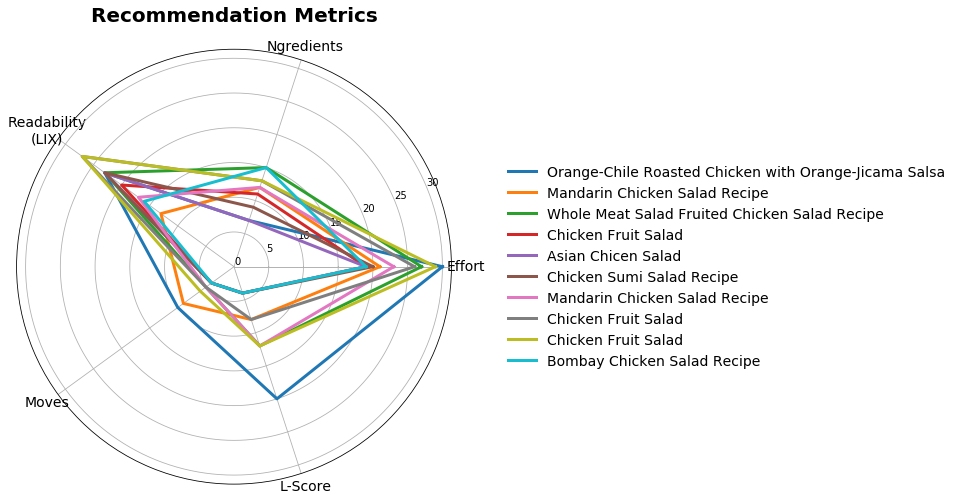


2 navel oranges
3 tbsp. a.1. dry rub bold original, divided
1/3 cup kraft zesty italian dressing
1 broiler-fryer chicken (3 lb.)
1 small jicama, peeled, chopped
1 red pepper, chopped
3 green onions, sliced

Heat oven to 400F.
 Grate 1 tsp.
 zest from 1 orange.
 Mix 1/2 tsp.
 zest, 1/2 tsp.
 rub seasoning and dressing; reserve for later use.
 Combine remaining zest and rub seasoning; rub onto outside of chicken, under chicken skin and inside chicken cavities.
 Place on rack in roasting pan.
 Bake 50 to 55 min.
 or until chicken is done (165F).
 Peel oranges; separate into segments.
 Cut segments into thirds, reserving juices.
 Mix dressing with reserved juices.
 Combine oranges, jicama, peppers, onions and reserved dressing mixture.
 Serve chicken with dressing mixture and fruit salsa.

http://www.kraftrecipes.com/recipes/orange-chile-roasted-chicken-orange-jicama-salsa-155130.aspx



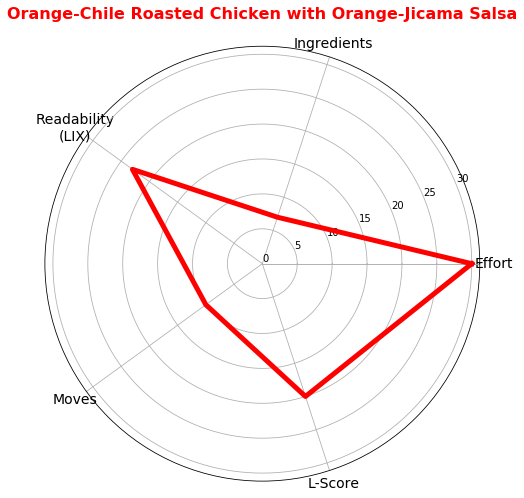


2 c. cooked chicken
1 tbsp. chopped onion
1 teaspoon salt
1 c. seedless grapes, halved
1 c. celery, diced
1 (11 ounce.) mandarin oranges, liquid removed
1/3 c. slivered almonds
1 tbsp. lemon juice
1 c. (4 ounce.) macaroni rings
1 c. salad dressing
1 c. cream, whipped

Combine chicken, onion and salt.
 Chill for several hrs.
 Add in grapes, celery, oranges, almonds and lemon juice to chicken mix.
 Pineapple cubes may be added, if wished.
 Add in salad dressing.
 Cook macaroni 5-6 min.
 Rinse in cool water.
 Drain and let cold.
 Stir into salad mix.
 When ready to serve, fold whip cream into mix.

http://cookeatshare.com/recipes/mandarin-chicken-salad-25714



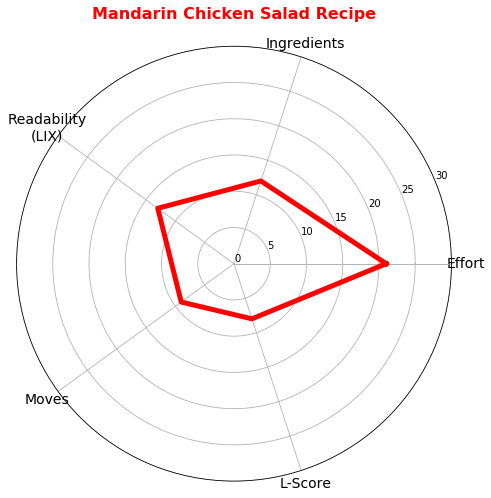


4 c. diced cooked chicken
1 (15 ounce.) can pineapple chunks, liquid removed
1 c. minced celery
1 c. salad dressing or possibly mayonnaise
1 (11 ounce.) can mandarin oranges, liquid removed
1/2 c. sliced, pitted ripe olives
1/2 c. minced green pepper
2 tbsp. grated onion
1 tbsp. prepared mustard
1 (5 ounce.) can chow mein noodles
lettuce leaves

In a large bowl, combine cooked chicken, pineapple, celery, oranges, olives, green pepper, and onion.
 Blend together mayonnaise Or possibly salad dressing and mustard.
 Toss gently with chicken mix.
 Cover and refrigeratefor several hrs.
 Just before serving, fold in chow mein noodles.
 Turn salad into a lettuce-lined serving bowl.

http://cookeatshare.com/recipes/whole-meat-salad-fruited-chicken-salad-44801



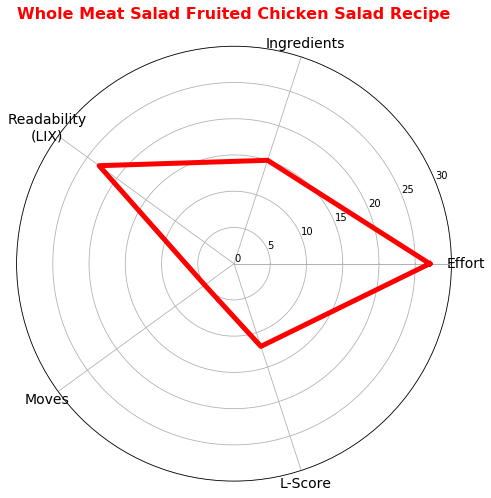


2-1/2 to 3 cup diced, cooked chicken
1 cup diced celery
2 tbsp. chopped green onion
1 tsp. salt
2 tbsp. lemon juice
1 can (11 oz.) mandarin oranges, well drained.
1 cup sliced seedless grapes (red
white)
1/2 cup slivered almonds, toasted
1/2 cup mayonnaise

Combine the chicken, celery and green onions.
 Mix in salt and lemon juice; chill covered several hours.
 Add oranges, grapes and almonds.
 Toss with mayonnaise, being careful not to break up orange slices.
 Serve on lettuce leaves with crackers of your choice.

http://www.foodgeeks.com/recipes/18430



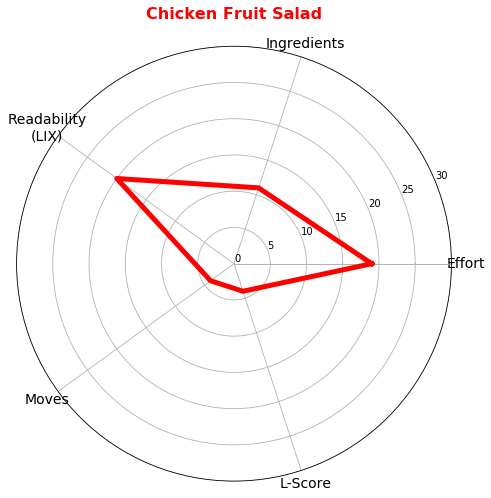


2 cups cooked chicken, skin removed and cut into bite-sized pieces
4 cups cabbage, shredded
1 cup mushroom, sliced
1 cup carrot, grated
2 tablespoons cilantro, chopped
1 cucumber, thinly sliced
3 green onions, thinly sliced
1 mandarin oranges or 1 tangerine, divided into sections
12 cup nonfat asian-style salad dressing or 12 cup nonfat oriental-style salad dressing
black pepper

In a large bowl, combine chicken, cabbage, mushrooms, carrots, cilantro, cucumber, and dressing.
 Toss well.
 Top with green onions and orange sections.
 Pepper to taste.
 Serves 4.

http://www.food.com/recipe/asian-chicen-salad-502059



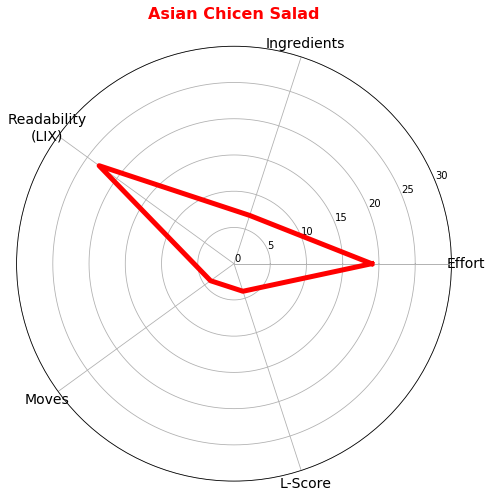


3 ounce. pkg. chicken flavor top ramen
1 sm. head cabbage (and - or possibly lettuce), minced
4 green onions, minced
1 can liquid removed mandarin oranges (save juice)
1 c. slivered almonds, toasted
2 tbsp. sesame seeds, toasted
2 c. cooked, shredded chicken, chilled

Remove flavor packet from Top Ramen and reserve for dressing (recipe follows).
 Crunch noodles into 1/2 inch pcs; set aside.
 Toss cabbage, onions, almonds, sesame seeds, mandarin oranges and chicken.
 Add in noodles and toss again.

http://cookeatshare.com/recipes/chicken-sumi-salad-38364



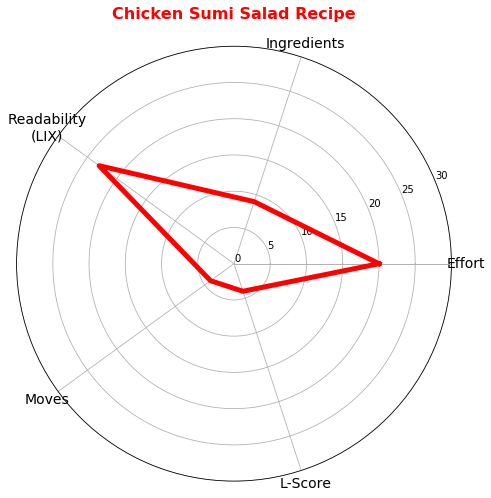


2-3 c. cooked chicken
1 tbsp. chopped onion
1 teaspoon salt
2 tbsp. lemon juice
1 c. thinly sliced celery
1 c. pineapple chunks, liquid removed
1/3 c. miracle whip salad dressing
1 can mandarin oranges, liquid removed
1/2 toasted slivered almonds

Mix chicken, onion, salt, lemon juice, and celery.
 Chill several hrs.
 At serving time, toss with rest of ingredients.
 Garnish with ripe olives and a few toasted almonds.
 Serve on lettuce leaves.
 Serves 6.
 Nice for a main dish luncheon salad.

http://cookeatshare.com/recipes/mandarin-chicken-salad-25728



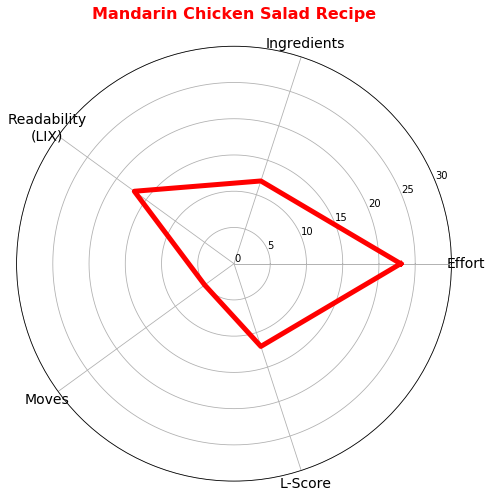


1/2 cup orzo pasta 
dressing: 
1/2 cup light mayonnaise (such as light miracle whip®) 
2 tablespoons dijon mustard 
2 tablespoons light sour cream 
1/2 cup orange juice 
1/2 teaspoon curry powder 
salt and ground black pepper to taste 
salad: 
1 (20 ounce) can pineapple tidbits, drained 
2 cups cubed cooked chicken 
2 stalks celery, diced 
1 fuji apple, cored and diced 
1 cup seedless green grapes, halved 
6 small green onions, minced 
1 (11 ounce) can mandarin oranges, drained 
2 tablespoons shelled salted pumpkin seeds, or to taste 


Bring a large pot of lightly salted water to a boil.
 Cook orzo in the boiling water, stirring occasionally until cooked through but firm to the bite, about 11 minutes.
 Drain and transfer to a bowl; refrigerate until chilled.

Whisk mayonnaise, Dijon mustard, sour cream, orange juice, curry powder, salt, and pepper together in a bowl until dressing is smooth; cover with plastic wrap and refrigerate until chilled, at least 30 minutes.

Mix pineapple, c

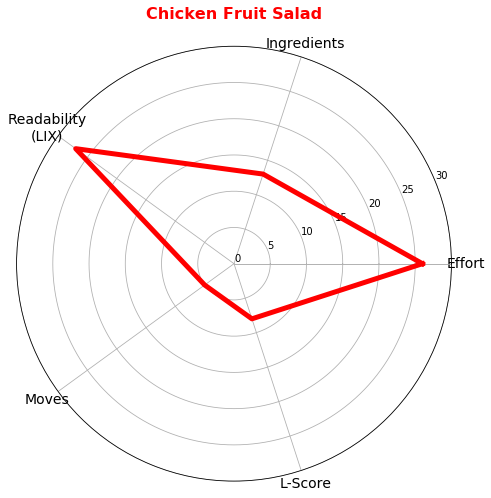


1/2 cup orzo pasta
dressing:
1/2 cup light mayonnaise (such as light miracle whip)
2 tablespoons dijon mustard
2 tablespoons light sour cream
1/2 cup orange juice
1/2 teaspoon curry powder
salt and ground black pepper to taste
salad:
1 (20 ounce) can pineapple tidbits, drained
2 cups cubed cooked chicken
2 stalks celery, diced
1 fuji apple, cored and diced
1 cup seedless green grapes, halved
6 small green onions, minced
1 (11 ounce) can mandarin oranges, drained
2 tablespoons shelled salted pumpkin seeds, or to taste

Bring a large pot of lightly salted water to a boil.
 Cook orzo in the boiling water, stirring occasionally until cooked through but firm to the bite, about 11 minutes.
 Drain and transfer to a bowl; refrigerate until chilled.
 Whisk mayonnaise, Dijon mustard, sour cream, orange juice, curry powder, salt, and pepper together in a bowl until dressing is smooth; cover with plastic wrap and refrigerate until chilled, at least 30 minutes.
 Mix pineapple, chicken, celery, app

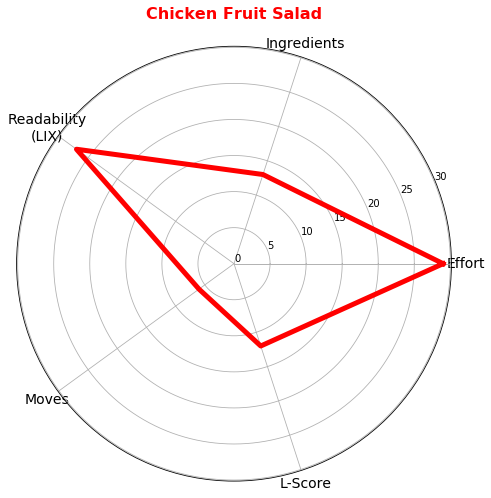


1/2 c. light lowfat sour cream
1/2 c. reduced-fat mayonnaise\', "3 tbsp. major grey\'s chutney juice of 1 lemon", \'3 c. cooked pasta, such as orecchiette, corkscrew or possibly penne
3 c. cooked cubed chicken
1/2 c. minced green onions
1/2 c. sliced celery
1 c. pitted and sliced dates
2 c. fresh or possibly canned pineapple chunks, liquid removed
1/2 c. toasted almonds, minced (see note)
1 x (11-oz) can mandarin oranges, liquid removed
1/2 c. golden brown raisins

Mix lowfat sour cream, mayonnaise, chutney and lemon juice in a large bowl.
 Add in pasta, chicken, green onions, celery, dates, pineapple, almonds, oranges and raisins, and toss gently.
 If you wish, refrigerateup to an hour before serving.
 Note: To toast nuts, heat in a dry skillet over medium heat till they start to brown.
 Stir occasionally.
 Be careful not to scorch them.
 - Trader Joe's
http://cookeatshare.com/recipes/bombay-chicken-salad-88918



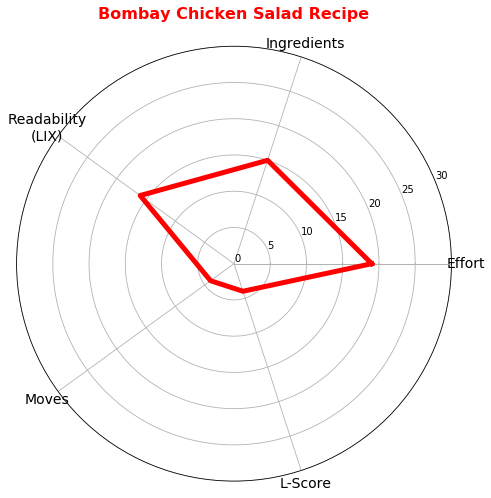

In [26]:
recommendations = recipe_recommender(result, 25)
display_recommendations(recommendations)

# Suggest Substitutions

Not a thorough implementation of this idea.

In [27]:
suggest_substitutions(25)

oranges ['lemons', 'peaches', 'apples']
tbsp ['tablespoon', 'tsp', 'tablespoons']
dressing ['salad', 'dressed', 'mayonnaise']
chicken ['pork', 'beef', 'sauce']
lb ['lbs', 'kg', 'pound']
jicama ['cilantro', 'celery', 'jalapeno', 'zucchini']
onions ['onion', 'garlic', 'tomatoes']
